## New York Police Complaints (2016 - 2019)

How do we deploy the NY police force to efficiently fight crime?



### Libraries and Python Packages

In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import os

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the file (2016 - 2019)

In [2]:
iter_csv = pd.read_csv('/content/drive/MyDrive/Monografia_NYPD/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[pd.to_datetime(chunk['fecha_suceso']).dt.year >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df = df[df['distrito'].isin(['MANHATTAN', 'BROOKLYN', 'BRONX'])]
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


###EDA

This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of last year (2019).
Available in: [Data, New York City](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i)

Considering the dataset is too big: 7'825.499, the data has been limited to 2016 until 2019 only.

In [3]:
print(f"This dataset for 2019 contains: {df.shape[0]} complaints and, a total of: {df.shape[1]} characteristics that describe the fact")

This dataset for 2019 contains: 1403924 complaints and, a total of: 22 characteristics that describe the fact


There are quite a few factors, but most are either: (1) identifying information (e.g. `num_denuncia`); or (2) too granular to start with (e.g. `geoespacial`). Therefore, we will first focus on the following variables: `tipo_crimen`, `lugar`, `distrito` (location types), `fecha_suceso` (time of occurrence) and `direccion_suceso` (geographic location), which give valuable information without getting too granular too quickly. Our outcome of interest is the number of crime incidents.

In [4]:
crimen_frequency_table = pd.DataFrame({'Count': df["tipo_crimen"].value_counts(), 'Percentage': df["tipo_crimen"].value_counts() / len(df) * 100})
crimen_frequency_table = crimen_frequency_table.sort_index().sort_values(by='Count', ascending=False)
crimen_frequency_table

,Count,Percentage
extorsion,554121,39.469444
incidentes_menores,265797,18.932435
crimenes_sexuales,228481,16.274456
delitos_graves,227624,16.213413
armas_drogas,90419,6.440448
otros_crimenes,37482,2.669803


Most of the complaints refer to a 'extorsion' facts in which they represent 39.22% of the total recorded crime data for 2019. Also it can be noticed that 'crimenes_sexuales' represent 17.86% of the total crime and it's curious that 'armas_drogas' represent only 4.29% of the data in a city (state) that is legal to possess shotguns or rifles.

In [5]:
lugar_frequency_table = pd.DataFrame({'Count': df["lugar"].value_counts(), 'Percentage': df["lugar"].value_counts() / len(df) * 100})
lugar_frequency_table = lugar_frequency_table.sort_index().sort_values(by='Count', ascending=False)
lugar_frequency_table

,Count,Percentage
lugares publicos,975097,69.455113
diversion y turismo,249851,17.796619
necesidades diarias,89923,6.405119
Otros,47179,3.360510
lugares solitarios,41874,2.982640


Most of the facts ocurred in 'lugares publicos' 70% and also places of 'diversion y turismo' which are also public places; there is an opportunity to propose a police strategy to deploy the workforce effiecently around those places to prevent or act in case a fact is in progress

In [6]:
df_distrito = df.groupby(['distrito', 'tipo_crimen']).size().reset_index(name='count')
#display(df_distrito)

In [7]:
# pivoted_df = df_distrito.pivot(index='distrito', columns='tipo_crimen', values='count')
pivoted_df = pd.pivot_table(df_distrito, index='distrito', columns='tipo_crimen', values='count', aggfunc='sum', margins=True, margins_name='Total')
pivoted_df

tipo_crimen,armas_drogas,crimenes_sexuales,delitos_graves,extorsion,incidentes_menores,otros_crimenes,Total
distrito,,,,,,,
BRONX,33117,70664,80239,129430,83660,8074,405184
BROOKLYN,30052,92046,87382,204314,107157,21523,542474
MANHATTAN,27250,65771,60003,220377,74980,7885,456266
Total,90419,228481,227624,554121,265797,37482,1403924


1. Among the listed boroughs, Brooklyn has the highest total count of crimes with 542,474 reported incidents, followed by Manhattan with 456,266 incidents. Bronx has lower total crime counts compared to the others.

2. The crime type with the highest count is "extorsion" with 554,121 incidents across all boroughs and what it is curious is that this number is close to the total incidents in Brooklyn. It is followed by "incidentes_menores" with 265,797 incidents.

3. In terms of individual boroughs:

* Brooklyn has the highest counts for "extorsion" (204,314 incidents), "incidentes menores" (107,157 incidents), and "crimenes_sexuales" (92,046 incidents).

* Manhattan has also the same trend with less reported incidents. 

* In Bronx crimen data is distributed a bit different: "extorsion" (129,420 incidents), "incidentes_menores" (83,660 incidents), and "delitos_graves" (80,239 incidents).

#### Contingency tables

So far, we have seen crime patterns linked with `tipo_crimen` and `lugar` separately. It makes sense to see whether a certain combination of crime type and location type is prevalent or not. We know that both `tipo_crimen` and `lugar` are discrete variables. We can therefore use a [**contingency table**](http://mathworld.wolfram.com/ContingencyTable.html) (cross table) to summarize the total number of incidents that belong to a specific combination of values of `tipo_crimen` and `lugar`.

We can use the function `crosstab` in `pandas` to generate the contingency table of two variables.

`crosstab(var1, var2)` generates the contingency table for `var1` vs. `var2`. Use this function to generate a contingency table for `tipo_crimen` vs. `lugar` where only the top 10 most prevalent crime locations and types are included.

In [8]:
df_1 = df[df["lugar"].isin(df["lugar"].value_counts().index[:10]) & df["tipo_crimen"].isin(df["tipo_crimen"].value_counts().index[:10])]
pd.crosstab(df_1["tipo_crimen"],df_1["lugar"])

lugar,Otros,diversion y turismo,lugares publicos,lugares solitarios,necesidades diarias
tipo_crimen,,,,,
armas_drogas,3222,1776,79042,1117,5262
crimenes_sexuales,7481,23110,174428,5364,18098
delitos_graves,8451,20049,179456,6647,13021
extorsion,14510,178726,303235,20035,37615
incidentes_menores,11616,24220,207608,8157,14196
otros_crimenes,1899,1970,31328,554,1731




1.   Extortion (extorsion) appears to be the most prevalent crime across all locations. It has the highest counts in all location categories, indicating that extortion incidents are relatively common regardless of the place where they occur.

2.   Crimes in public places (lugares publicos) also show relatively high counts across different crime types. This suggests that public locations are more susceptible to various types of crimes, including arms and drugs, sexual crimes, serious offenses, incidents of lesser severity, and other crimes.

3. The category of "diversion y turismo" (entertainment and tourism) exhibits notable counts for several crime types, including sexual crimes, serious offenses, incidents of lesser severity, and other crimes. This implies that entertainment and tourist spots may be vulnerable to a range of criminal activities.

4. "Lugares solitarios" (solitary places) generally have lower counts for most crime types compared to other locations. This indicates that crimes occurring in solitary or isolated places, such as remote areas or secluded spots, are relatively less frequent in this context.

5. Please keep in mind that these insights are based on the provided data and should be interpreted within the context of the specific dataset. Further analysis, such as statistical tests or comparison with additional data, may be required to draw more robust conclusions.

How can the above table help you deploy your workforce efficiently?

This analysis is most useful when we want to identify hot spots for a specific type of crime. For instance, if the police department considers eliminating 'crimenes_sexuales' as a priority, then the above table can tell us where we should deploy more police forces to combat sexual crime. The table gives us the following insights:

Other than theft, 'delitos_graves' tend to concentrate in fewer than three types of locations, which indicates location-specific patrolling is more efficient for combatting those types of crime.
'extorsion' offenses tend to be spread across all types of locations. It is the type of crime that would require more resources to control.

###Investigating crime by timestamp

We now move on to investigate the relationship between crime incidents and time; i.e. the `fecha_suceso` variable we pointed out early on. Time is one of the most important dimensions for constructing an effective deployment plan. Since we cannot patrol every location 24/7, we must target periods of time with high crime rates. `fecha_suceso` gives us a timestamp for each incident, which allows us to count how many incidents happened within a given period of time. Since we have one year's worth of data, we can start with monthly total incidents to see if certain months are crime-prone.

We have covered a few cases dealing with temporal data and we generally group by different units of time (days, weeks, months) to discover different insights from the data. As we investigate from a temporal perspective, it is important to keep the concept of confounding variables. An example would be discovering a pattern regarding MONTHS having more crime but the underlying factor is actually temperature. If New York had a particularly hot MONTH in the future, a careful data scientist would expect more crimes rather than simply concluding that MONTH always has fewer crimes than MONTHS.

In [9]:
# convert string to datatime 
df["fecha_suceso"].info()

<class 'pandas.core.series.Series'>
Int64Index: 1403924 entries, 0 to 5549517
Series name: fecha_suceso
Non-Null Count    Dtype 
--------------    ----- 
1403924 non-null  object
dtypes: object(1)
memory usage: 21.4+ MB


In [10]:
def plot_time( df, time_var, title, rot = 0):
    res = df.groupby([time_var])['num_denuncia'].count().reset_index(name="count")
    p = res.plot(x = time_var, y = "count", title = title, rot = rot)
    return p

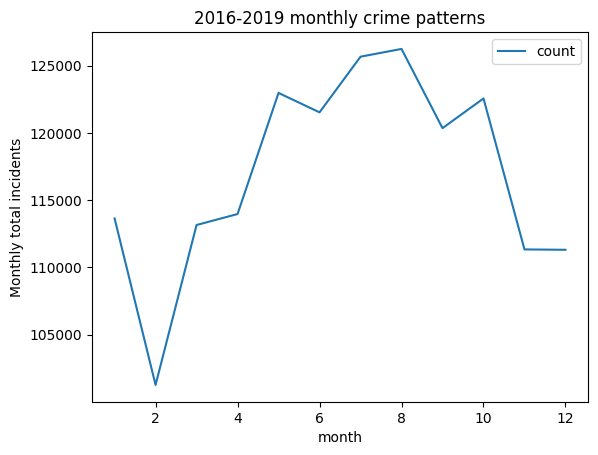

In [11]:
df["fecha_suceso"] = pd.to_datetime(df["fecha_suceso"])  # Convert to datetime type
df["month"] = df.fecha_suceso.dt.month
p_monthly = plot_time(df, "month", "2016-2019 monthly crime patterns")
_ = plt.ylabel("Monthly total incidents")

Which months have relatively higher crime rates? Why?

Answer. Feburary has the lowest number of total incidents and crime incidents peak in July. Overall, more incidents occurred during the summer. This makes sense because New York is cold and windy in the winter, and neither perpetrators nor victims like to be out and about much then! Also since the dataset contains transit infractions registered this is aligned with the fact that temperature plays important role in total cases.

<Figure size 1600x600 with 0 Axes>

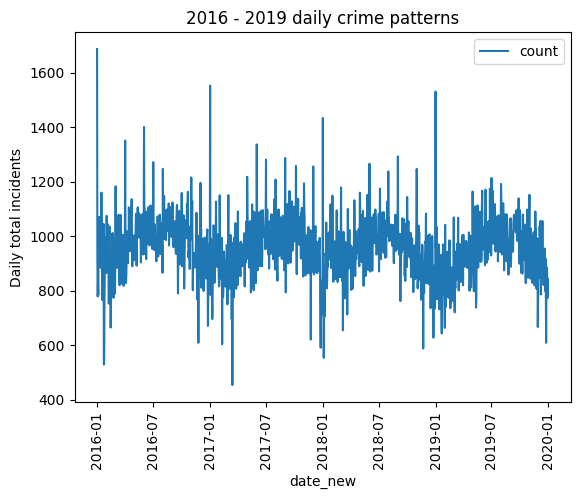

In [12]:
df["date_new"] = df.fecha_suceso.dt.date
# rotate the x-axis tick labels for better visualization
plt.figure(figsize=(16, 6))
p_daily = plot_time(df, "date_new", "2016 - 2019 daily crime patterns", rot = 90)
_ = plt.ylabel("Daily total incidents")

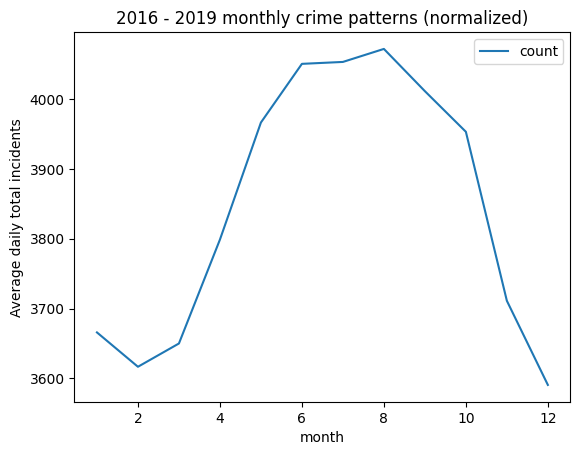

In [13]:
res = df.groupby(["month"])["num_denuncia"].count().reset_index(name="count")
res["count"] = res["count"]/[31,28,31,30,31,30,31,31,30,31,30,31]
_ = res.plot(x = "month", y = "count", title = "2016 - 2019 monthly crime patterns (normalized)")
_ = plt.ylabel("Average daily total incidents")

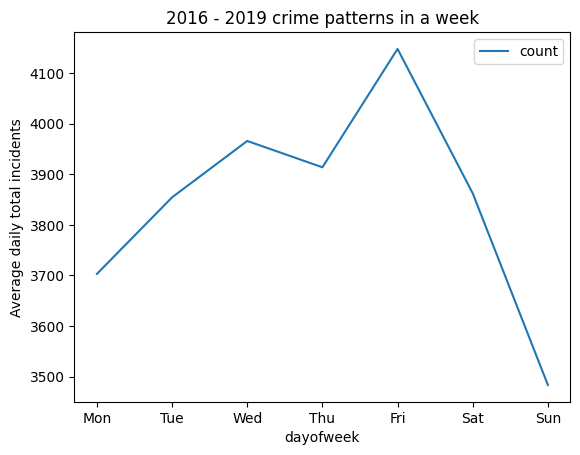

In [14]:
df["dayofweek"] = df.fecha_suceso.dt.dayofweek.astype("category")
df.dayofweek = df.dayofweek.cat.rename_categories(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
res = df.groupby(["dayofweek"])['num_denuncia'].count().reset_index(name="count")
res['count'] = res['count']/pd.date_range("2017-1-1","2017-12-31",freq="D").dayofweek.value_counts()[::-1]
_ = res.plot(x="dayofweek", y = "count", title = "2016 - 2019 crime patterns in a week")
_ = plt.ylabel("Average daily total incidents")

We find that Friday has significantly higher total incidents compared to all other days of week. The lowest total incidents is reached on Sundays.

In [15]:
import branca
beat_cn = df.groupby("direccion_suceso")["num_denuncia"].count().reset_index(name="crime_count")

# color scheme
min_cn, max_cn = beat_cn['crime_count'].quantile([0.01,0.99]).apply(round, 2)

colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=min_cn,
    vmax=max_cn
)
colormap.caption="Total crimes in Chicago by police beats"

Crime type vs. day of the week

In [16]:
res_raw = pd.crosstab(df["tipo_crimen"], df.dayofweek)
res_raw/pd.date_range("2016-1-1","2019-12-31",freq="D").dayofweek.value_counts().tolist()[::-1]

dayofweek,Mon,Tue,Wed,Thu,Fri,Sat,Sun
tipo_crimen,,,,,,,
armas_drogas,37.471154,66.221154,76.698565,74.392344,75.291866,63.622010,39.425837
crimenes_sexuales,158.447115,160.230769,162.114833,158.966507,164.076555,145.483254,145.416268
delitos_graves,147.932692,142.596154,147.880383,144.191388,156.038278,175.660287,176.200957
extorsion,382.134615,389.096154,391.866029,388.196172,415.784689,364.741627,323.167464
incidentes_menores,176.567308,179.668269,181.301435,181.956938,193.956938,185.301435,174.708134
otros_crimenes,23.225962,25.812500,26.889952,26.086124,26.885167,26.205742,24.468900


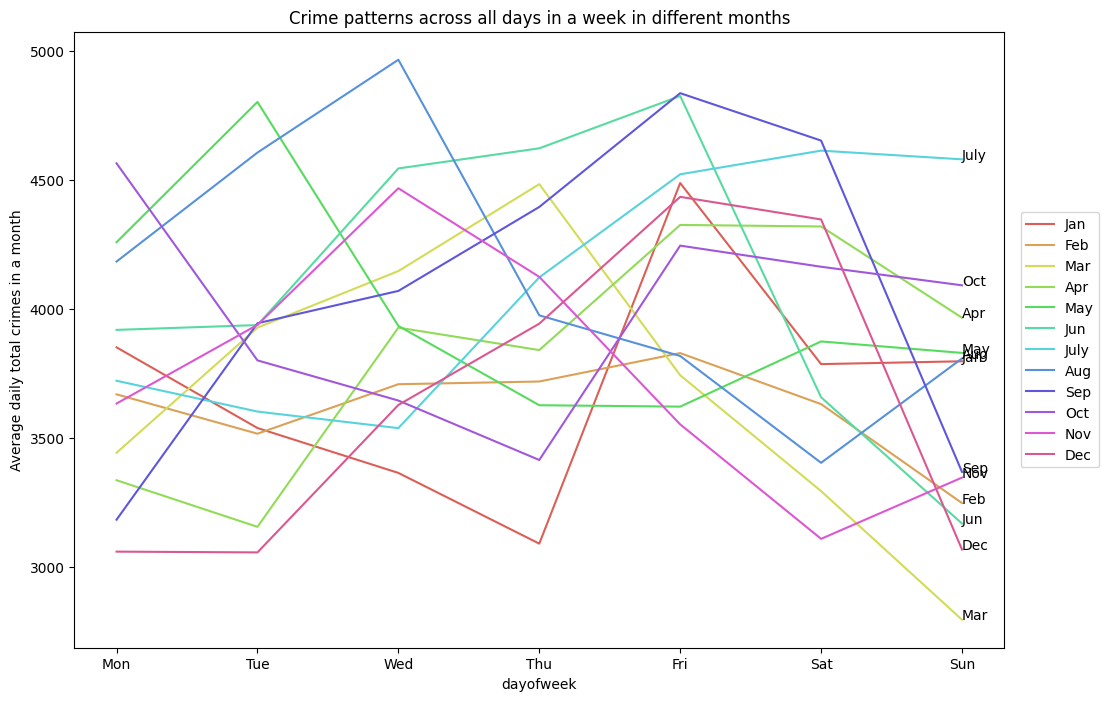

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the width and height as desired

# Perform the calculations and data manipulation
res_md = df.groupby(['dayofweek', 'month'])['num_denuncia'].count().reset_index(name="count")
date_2019 = pd.DataFrame(
    {"dayofweek": pd.date_range("2019-1-1", "2019-12-31", freq="D").dayofweek.astype("category"),
     "month": pd.date_range("2017-1-1", "2017-12-31", freq="D").month})
date_2019["dayofweek"] = date_2019["dayofweek"].cat.rename_categories(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
nd_2019 = date_2019.groupby(['month'])['dayofweek'].value_counts().sort_index().reset_index(name="day_count")
res_md_norm = nd_2019.merge(res_md, how="left", on=["month", "dayofweek"])
res_md_norm['count_norm'] = res_md_norm['count'] / res_md_norm['day_count']

res_md_norm['dayofweek'] = res_md_norm['dayofweek'].astype("category").cat.reorder_categories(
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
res_md_norm['month'] = res_md_norm['month'].astype('category').cat.rename_categories(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Plot the chart
mp = sns.lineplot(data=res_md_norm, x='dayofweek', hue='month', y='count_norm',
                  palette=sns.color_palette("hls", 12))

# Customize the chart
mp = mp.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1)
_ = plt.ylabel("Average daily total crimes in a month")
_ = plt.title("Crime patterns across all days in a week in different months")

# Add text labels to each line
for i in range(12):
    tmp = res_md_norm[res_md_norm.dayofweek == "Sun"]
    _ = plt.text(6, tmp['count_norm'].iloc[i], tmp['month'].iloc[i])

# Show the chart
plt.show()


As the above chart shows, across all of the months there might be a pattern when the weekend comes as in most of them the total facts increase. This could be aligned with the fact that 'Lugares Publicos' and 'Extorsion' are also related and those days is when usuaylly people are more outside. 

###Conclusions

This notebook explored NYC crime complaints in a range of 2016 to 2019 with the idea of understanding crime patterns and proposed preliminary policy deployment strategies based on these patterns. It initially examined the patterns associated with each variable of interest independently. Based on the single variable analyses, this proposed that the police department should put extra forces to work on Fridays between May and August, pay more attention to extorsion, sexual crimes, homicide and criminal damage, and deploy more forces in Brooklyn, Bronx and Manhattan.

Then this conducted analyses for three pairs of variables and found that the above strategies are too rigid and don't take into account interaction effects. We found that Friday is a weekly hot spot outside of summertime, but during summertime, either Saturday becomes the hot spot or no hot spot was present at all.

Moving forward, there are many things we can do. Using this dataset, we can explore other pairwise interaction effects. We can also examine if the strategies we proposed here have already been implemented and whether the deployment plan in use now is successful or not. We can also consider more advanced statistical modeling for our dataset so that all variables can be included, and not just the ones we examined. For those that are interested in this topic, a good starting point is here.

###Takeaways

This type of data does not have as clear of an outcome of interest, so we started by assuming that the outcome of interest is the total number of crime incidents. 

When investigating variables of interest, we did not use correlation matrices because these make little sense for categorical variables.
Instead, we used tools such as frequency tables and contingency tables.
We also learned the importance of normalization to ensure that you are making apples-to-apples comparisons.

Finally, this questioned the original assumption that the number of crime incidents was the most important outcome to optimize for. This also looked at how it ought to weight different crimes differently in our analysis based on the particular business problem at hand.